Here, we'll explore a step-by-step process for Text Preprocessing:

1. Lowercasing.
2. Remove HTML tags.
3. Remove URLs.
4. Remove punctuations.
5. Chat words (Short form) treatment.
6. Spelling correction.
7. Removing stop words.
8. Handling emojis.
9. Tokenization.
10. Stemming.
11. Lemmatization.


### Downloading Data

There may be different sources to get the data:

* CSV files
* SQL databases
* Raw File URLs
* Kaggle datasets
* Google Drive
* Dropbox
* etc.

Identify the right tool/library to get the data.

We'll use TMDB APIs to download the data and convert it into CSV file.

We will take 3 columns
  * Name
  * Description
  * Genre



In [11]:
import requests
import pandas as pd
import time

API_KEY = "8265bd1679663a7ea12ac168da84d2e8"

BASE_URL = "https://api.themoviedb.org/3"

# Get Genre Mapping

def get_genres():
    url = f"{BASE_URL}/genre/movie/list?api_key={API_KEY}&language=en-US"
    response = requests.get(url)
    response.raise_for_status()
    genres = {g["id"]: g["name"] for g in response.json()["genres"]}
    return genres

# Get Movies Page by Page

def get_movies(page):
    url = f"{BASE_URL}/movie/popular?api_key={API_KEY}&language=en-US&page={page}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()["results"]

# Step 3: Build Full Dataset

def create_full_dataset(total_pages=471):
    genres = get_genres()
    all_movies = []

    for page in range(1, total_pages + 1):
        try:
            movies = get_movies(page)
            for movie in movies:
                all_movies.append({
                    "Name": movie.get("title", ""),
                    "Description": movie.get("overview", ""),
                    "Genre": ", ".join([genres.get(gid, "Unknown") for gid in movie.get("genre_ids", [])])
                })
        except Exception as e:
            print(f"⚠️ Error on page {page}: {e}")
            continue

        # Save progress every 20 pages
        if page % 20 == 0:
            pd.DataFrame(all_movies).to_csv("tmdb_movies_partial.csv", index=False, encoding="utf-8")

        # Be nice to API (avoid getting blocked)
        time.sleep(0.5)

    # Save final dataset
    df = pd.DataFrame(all_movies)
    df.to_csv("tmdb_movies.csv", index=False, encoding="utf-8")

# Run Script

if __name__ == "__main__":
    create_full_dataset(total_pages=471)


Downloading file to see it.
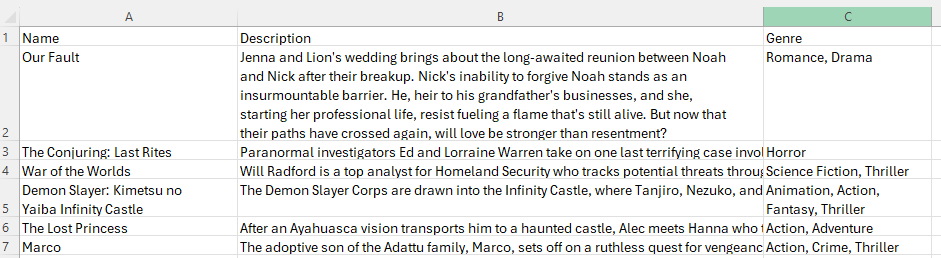

In [62]:
from google.colab import files
files.download("tmdb_movies.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import pandas as pd
df = pd.read_csv("tmdb_movies.csv")
df.head()

,Name,Description,Genre
0,Our Fault,Jenna and Lion's wedding brings about the long...,"Romance, Drama"
1,The Conjuring: Last Rites,Paranormal investigators Ed and Lorraine Warre...,Horror
2,War of the Worlds,Will Radford is a top analyst for Homeland Sec...,"Science Fiction, Thriller"
3,Demon Slayer: Kimetsu no Yaiba Infinity Castle,The Demon Slayer Corps are drawn into the Infi...,"Animation, Action, Fantasy, Thriller"
4,The Lost Princess,After an Ayahuasca vision transports him to a ...,"Action, Adventure"


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9418 entries, 0 to 9417
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         9418 non-null   object
 1   Description  9147 non-null   object
 2   Genre        8996 non-null   object
dtypes: object(3)
memory usage: 220.9+ KB


In [67]:
df.describe()

,Name,Description,Genre
count,9419,9156,8970
unique,8913,8884,1769
top,Sleeping Beauty,Pink film directed by Tarô Araki.,Drama
freq,5,4,896


### LowerCasing

As Python is a case sensitive language, during token conversion, a sentence like:-
* Basically, it's how it can be done **so** easily. **So** try to enjoy.

In this sentence, "So" and "so" will be converted into 2 different tokens. That's why we need to convert text into lower case

In [68]:
df['Description'][3].lower()

'the demon slayer corps are drawn into the infinity castle, where tanjiro, nezuko, and the hashira face terrifying upper rank demons in a desperate fight as the final battle against muzan kibutsuji begins.'

In [70]:
df['Description']=df['Description'].str.lower()
df

,Name,Description,Genre
0,Our Fault,jenna and lion's wedding brings about the long...,"Romance, Drama"
1,The Conjuring: Last Rites,paranormal investigators ed and lorraine warre...,Horror
2,War of the Worlds,will radford is a top analyst for homeland sec...,"Science Fiction, Thriller"
3,Demon Slayer: Kimetsu no Yaiba Infinity Castle,the demon slayer corps are drawn into the infi...,"Animation, Action, Fantasy, Thriller"
4,The Lost Princess,after an ayahuasca vision transports him to a ...,"Action, Adventure"
...,...,...,...
9414,Rated 19 Secret Lesson,"yoo-jeong, who was in a relationship with hoon...",Drama
9415,"The Trouble with 2b: Part One, Happy Days",a series of six short films concerning the adv...,NaN
9416,Andre the Giant,an ambitious and wide-ranging documentary expl...,Documentary
9417,The Spider and the Fly,"""the spider and the fly is set in paris during...","Crime, Thriller"


![separator2](https://i.imgur.com/4gX5WFr.png)

### Remove HTML Tags

When we perform web scraping, the text data we get includes HTML tags. These tags create problem during modelling.

We will remove it by usin regular expression.

In [19]:
import re
def remove_html(text):
  exp = re.compile('<.*?>')
  return exp.sub(r'', text)

In [20]:
text = '<html> <div>Hello <h1> Ram </h1> </div> </html>'

In [21]:
remove_html(text)

' Hello  Ram   '

![separator2](https://i.imgur.com/4gX5WFr.png)

### Remove URLs

Links like https://... don’t carry semantic meaning for most NLP tasks.

Removing URLs helps in reducing noise and focusing on relevant words.

In [22]:
def remove_url(text):
  exp = re.compile(r'https?://\S+|www\.\S+')
  return exp.sub(r'', text)

In [23]:
t1 = 'My notebook https://www.google.com'
t2 = 'see google www.google.com'

In [24]:
remove_url(t1)

'My notebook '

![separator2](https://i.imgur.com/4gX5WFr.png)

### Remove Punctuation

Reason for removing Punctuations:
  1. Punctuation marks (.,!?) don’t usually add meaning for models unless sentiment or tone is analyzed.
  2. Words like “Hello!” may get converted into tokens which is not right.

Removing punctuation simplifies text structure and reduces unnecessary tokens.


In [25]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
pun = string.punctuation

In [27]:
def remove_punctuation(s):
  for c in pun:
    s = s.replace(c,'')
  return s

In [ ]:
#for i in range(len(df)):
#    df.loc[i, "Description"] = remove_punctuation(str(df.loc[i, "Description"]))

In [30]:
def rem(s):
  return str(s).translate(str.maketrans('','',pun))

In [31]:
df['Description']=df['Description'].apply(rem)

In [32]:
df['Description'][3]

'The Demon Slayer Corps are drawn into the Infinity Castle where Tanjiro Nezuko and the Hashira face terrifying Upper Rank demons in a desperate fight as the final battle against Muzan Kibutsuji begins'

![separator2](https://i.imgur.com/4gX5WFr.png)

### Chat word (Slangs) Treatment

In informal text (like chats or tweets), words are shortened (e.g., “u” → “you”, “brb” → “be right back”).

Expanding these improves clarity and helps the model understand true word meaning.

List of these words:

In [ ]:
t="""
A3=Anytime, Anywhere, Anyplace
ADIH=Another Day In Hell
AFK=Away From Keyboard
AFAIK=As Far As I Know
ASAP=As Soon As Possible
ASL=Age, Sex, Location
ATK=At The Keyboard
ATM=At The Moment
BAE=Before Anyone Else
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRUH=Bro
BRT=Be Right There
BSAAW=Big Smile And A Wink
BTW=By The Way
BWL=Bursting With Laughter
CSL=Can’t Stop Laughing
CU=See You
CUL8R=See You Later
CYA=See You
DM=Direct Message
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FIMH=Forever In My Heart
FOMO=Fear Of Missing Out
FR=For Real
FWIW=For What It's Worth
FYP=For You Page
FYI=For Your Information
G9=Genius
GAL=Get A Life
GG=Good Game
GMTA=Great Minds Think Alike
GN=Good Night
GOAT=Greatest Of All Time
GR8=Great!
HBD=Happy Birthday
IC=I See
ICQ=I Seek You
IDC=I Don’t Care
IDK=I Don't Know
IFYP=I Feel Your Pain
ILU=I Love You
ILY=I Love You
IMHO=In My Honest/Humble Opinion
IMU=I Miss You
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
IYKYK=If You Know, You Know
JK=Just Kidding
KISS=Keep It Simple, Stupid
L=Loss
L8R=Later
LDR=Long Distance Relationship
LMK=Let Me Know
LMAO=Laughing My A** Off
LOL=Laughing Out Loud
LTNS=Long Time No See
M8=Mate
MFW=My Face When
MID=Mediocre
MRW=My Reaction When
MTE=My Thoughts Exactly
NVM=Never Mind
NRN=No Reply Necessary
NPC=Non-Player Character
OIC=Oh I See
OP=Overpowered
PITA=Pain In The A**
POV=Point Of View
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A** Off
RN=Right Now
SK8=Skate
STATS=Your Sex And Age
SUS=Suspicious
TBH=To Be Honest
TFW=That Feeling When
THX=Thank You
TIME=Tears In My Eyes
TLDR=Too Long, Didn’t Read
TNTL=Trying Not To Laugh
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
W=Win
W8=Wait...
WB=Welcome Back
WTF=What The F**k
WTG=Way To Go!
WUF=Where Are You From?
WYD=What You Doing?
WYWH=Wish You Were Here
ZZZ=Sleeping, Bored, Tired
"""
slangs = dict(line.split("=", 1) for line in t.strip().split("\n"))

In [ ]:
slangs

{'A3': 'Anytime, Anywhere, Anyplace',
 'ADIH': 'Another Day In Hell',
 'AFK': 'Away From Keyboard',
 'AFAIK': 'As Far As I Know',
 'ASAP': 'As Soon As Possible',
 'ASL': 'Age, Sex, Location',
 'ATK': 'At The Keyboard',
 'ATM': 'At The Moment',
 'BAE': 'Before Anyone Else',
 'BAK': 'Back At Keyboard',
 'BBL': 'Be Back Later',
 'BBS': 'Be Back Soon',
 'BFN': 'Bye For Now',
 'B4N': 'Bye For Now',
 'BRB': 'Be Right Back',
 'BRUH': 'Bro',
 'BRT': 'Be Right There',
 'BSAAW': 'Big Smile And A Wink',
 'BTW': 'By The Way',
 'BWL': 'Bursting With Laughter',
 'CSL': 'Can’t Stop Laughing',
 'CU': 'See You',
 'CUL8R': 'See You Later',
 'CYA': 'See You',
 'DM': 'Direct Message',
 'FAQ': 'Frequently Asked Questions',
 'FC': 'Fingers Crossed',
 'FIMH': 'Forever In My Heart',
 'FOMO': 'Fear Of Missing Out',
 'FR': 'For Real',
 'FWIW': "For What It's Worth",
 'FYP': 'For You Page',
 'FYI': 'For Your Information',
 'G9': 'Genius',
 'GAL': 'Get A Life',
 'GG': 'Good Game',
 'GMTA': 'Great Minds Think Alik

In [ ]:
def chat(text):
  new=[]
  for word in text.split():
    if word.upper() in slangs:
      new.append(slangs[word.upper()])
    else:
      new.append(word)
  return " ".join(new)

![separator2](https://i.imgur.com/4gX5WFr.png)

### Spelling Correction

Misspelled words (“enviroment” → “environment”) can confuse models and create extra unique tokens.

For this we use **TextBlob** library which helps in correcting those words.

In [33]:
from textblob import TextBlob

In [34]:
incorrect = 'this is best notebook among all the ntebook he has'
correct = TextBlob(incorrect)
correct.correct().string

'this is best notebook among all the notebook he has'

![separator2](https://i.imgur.com/4gX5WFr.png)

### Removing Stop Words

Common words (like “the”, “is”, “and”) occur frequently but add little meaning.

Removing stop words reduces dimensionality and highlights important words.

NLTK Library has this list of stopwords.

In [35]:
from nltk.corpus import stopwords

In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
stopwords.words('english')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [38]:
def remove_words(text):
  new=[]
  for c in text.split():
    if c not in stopwords.words('english'):
      new.append(c)
    else:
      new.append('')
  x = new[:]
  new.clear()
  return " ".join(x)

In [39]:
remove_words(df['Description'][3])

'The Demon Slayer Corps  drawn   Infinity Castle  Tanjiro Nezuko   Hashira face terrifying Upper Rank demons   desperate fight   final battle  Muzan Kibutsuji begins'

![separator2](https://i.imgur.com/4gX5WFr.png)

### Handling Emojis

Emojis carry emotional or contextual meaning (😊 → happy, 😢 → sad).
Model can't understand those. So we can:
  * Remove them.
  * Retain them by suitable meaning.

In [41]:
import re

def remove_emoji(text):
    emojis = re.compile(
        "["
        u"\U0001F600-\U0001F64F" # emoticons
        u"\U0001F300-\U0001F5FF" # symbols & pictographs
        u"\U0001F680-\U0001F6FF" # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

In [42]:
remove_emoji('Loved this movie. It was ❤️')

'Loved this movie. It was '

In [43]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 12.6 MB/s eta 0:00:00


In [44]:
import emoji
emoji.demojize('It was ❤️')

'It was :red_heart:'

![separator2](https://i.imgur.com/4gX5WFr.png)

### Tokenization

Tokenization splits text into smaller units (words, subwords, or sentences). We can do this by:
  * Using split() function.
      * may not perform well.
  * word_tokenize, sent_tokenize from nltk library.
      * better than split.

This is first step for NLP, which helps model to analyze text at word level.

In [45]:
text = df['Description'][3]
text.split()

['The',
 'Demon',
 'Slayer',
 'Corps',
 'are',
 'drawn',
 'into',
 'the',
 'Infinity',
 'Castle',
 'where',
 'Tanjiro',
 'Nezuko',
 'and',
 'the',
 'Hashira',
 'face',
 'terrifying',
 'Upper',
 'Rank',
 'demons',
 'in',
 'a',
 'desperate',
 'fight',
 'as',
 'the',
 'final',
 'battle',
 'against',
 'Muzan',
 'Kibutsuji',
 'begins']

In [46]:
#text.split('.')
text = 'I am happy!! My email is abs@gmail.com'
text.split()

['I', 'am', 'happy!!', 'My', 'email', 'is', 'abs@gmail.com']

In [47]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [48]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [49]:
word_tokenize(text)

['I', 'am', 'happy', '!', '!', 'My', 'email', 'is', 'abs', '@', 'gmail.com']

In [ ]:
text= """ I am going to Delhi. I am happy. I will go on Sunday. """
sent_tokenize(text)

[' I am going to Delhi.', 'I am happy.', 'I will go on Sunday.']

![separator2](https://i.imgur.com/4gX5WFr.png)

### Stemming

Stemming is the process of reducing a word to its root form by chopping off suffixes or prefixes. It does not guarantee that the resulting word is a valid word. Common algorithm: **Porter Stemmer, Snowball Stemmer**

Example:
  * "Playing" → "Play"
  * "Studies" → "Studi"

In [51]:
from nltk.stem.porter import PorterStemmer

In [52]:
ps = PorterStemmer() # Create an instance of PorterStemmer
def stem(text):
  return " ".join([ps.stem(w) for w in text.split()])

In [53]:
text = "walking walk walked walks"
stem(text)

'walk walk walk walk'

![separator2](https://i.imgur.com/4gX5WFr.png)

### Lemmatization

Lemmatization reduces words to their meaningful base form called lemma, considering vocabulary and morphological analysis. It produces valid words. Uses a dictionary-based approach with **WordNet** Lemmatizer.

Example:
  * "Playing" → "Play"
  * "Studies" → "Study"

In [54]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [55]:
lemmatizer = WordNetLemmatizer()

In [57]:
text = ["running", "flies", "better", "studies", "feet"]
lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
lemmatized_words

['running', 'fly', 'better', 'study', 'foot']